In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from mnist import MNIST

/home/azfar305/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%reload_ext autoreload 
%matplotlib inline
%autoreload 2
from utilities import *

# Default figure size
plt.rcParams['figure.figsize'] = (7,5)

In [3]:
PATH = './data/fashion/'
data = MNIST(PATH)
data.gz = True
images,labels = data.load_training()

In [4]:
X_train = np.array(images).T
Y_train = np.array(labels)

In [5]:
classes = np.unique(Y_train)
C = classes.size; classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [6]:
description = {0:'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',
               4:'Coat',5:'Sandal',6:'Shirt',7:'Sneaker',
               8:'Bag',9:'Ankle boot'}
description

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [7]:
pos = []
for val in classes:
    pos.append(np.where(Y_train == val)[0][0])

In [8]:
def plot_data(X,Y,description,num = 30,pos = None):
    
    if pos is None:
        pos = np.random.choice(Y.size,num,replace=False)
        width = 6
        height = math.ceil(num/width)
        fig = plt.figure(figsize=(width*1.8,height*1.8))
        for i in range(num):
            fig.add_subplot(height,width,i+1)
            img = X[:,pos[i]].reshape(28,28)
            plt.imshow(img,cmap='gray')
            if description is not None:
                plt.title(description[Y[pos[i]]])
            plt.axis('off')
        plt.subplots_adjust(hspace = 0.6)
        plt.show()
        
    else:
        if len(pos) > num:
            pos = np.random.choice(pos,num)
        width = min(math.ceil(len(pos)/2),6)
        height = math.ceil(len(pos)/width)
        fig = plt.figure(figsize=(width*1.8,height*1.8))
        for i,val in enumerate(pos):
            fig.add_subplot(height,width,i+1)
            img = X[:,val].reshape(28,28)
            plt.imshow(img,cmap='gray')
            if description is not None:
                plt.title(description[Y[val]])
            plt.axis('off')
        plt.subplots_adjust(hspace = 0.6)
        plt.show()
        

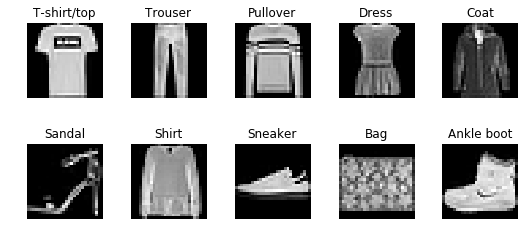

In [9]:
plot_data(X_train,Y_train,description,pos = pos)

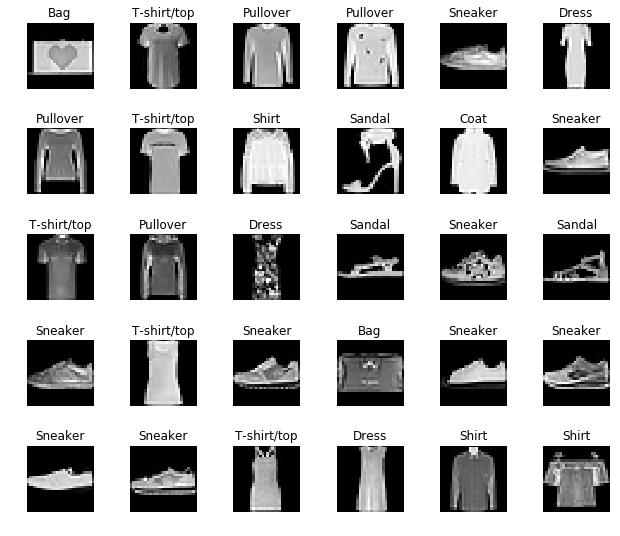

In [10]:
plot_data(X_train,Y_train,description)

Keys:  [0, 6, 2, 4]


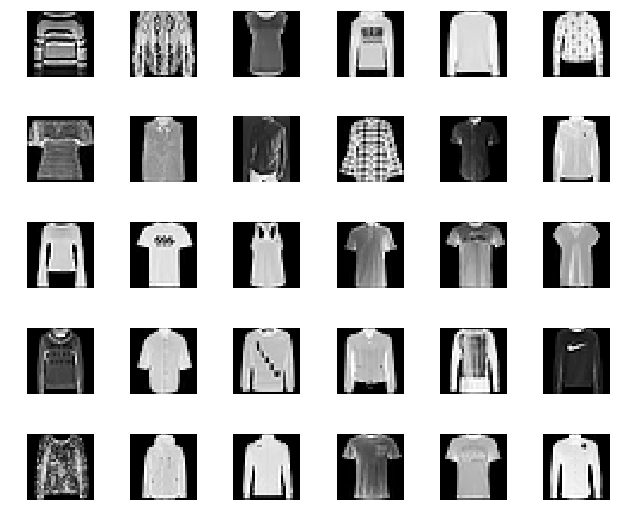

In [11]:
# Impossible to distinguish between T-shirt,Shirt,Pullover,Coat
indices = []
indices.append(list(description.values()).index('T-shirt/top'))
indices.append(list(description.values()).index('Shirt'))
indices.append(list(description.values()).index('Pullover'))
indices.append(list(description.values()).index('Coat'))
print('Keys: ',indices)
val = np.where(np.isin(Y_train,indices) == True)[0]
plot_data(X_train,Y_train,description=None,num=30,pos=val)

In [12]:
flip_X = horizontal_flip(X_train)

In [13]:
flip_X.shape

(784, 60000)

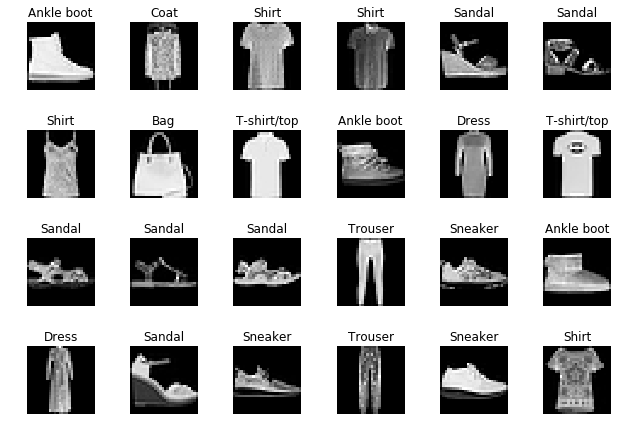

In [14]:
plot_data(flip_X,Y_train,description,num=24)

In [15]:
X_train = np.c_[X_train,flip_X]

X_train.shape

(784, 120000)

In [16]:
Y_train = np.append(Y_train,Y_train)

Y_train.shape

(120000,)

In [17]:
X_train = X_train/255

Yhot_train = one_hot_matrix(Y_train,C)

In [18]:
X_train.shape,Yhot_train.shape

((784, 120000), (10, 120000))

In [19]:
# Loading test set
# Performing the same preprocessing on the test set 
images,labels = data.load_testing()
X_test = np.array(images).T/255
Y_test = np.array(labels)

In [20]:
X_test.shape,Y_test.shape

((784, 10000), (10000,))

In [21]:
# Getting rid of unnecessary stuff
del(flip_X);del(images);del(labels)

In [23]:
# Sanity checking params_initialization
tf.reset_default_graph()
layers = [X_train.shape[0],25,12,C]
params = params_initialization(layers,0.0)
print("W1 = " + str(params["W1"]))
print("b1 = " + str(params["b1"]))
print("W2 = " + str(params["W2"]))
print("b2 = " + str(params["b2"]))
print("W3 = " + str(params["W3"]))
print("b3 = " + str(params["b3"]))

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
W1 = <tf.Variable 'W1:0' shape=(25, 784) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref>
W3 = <tf.Variable 'W3:0' shape=(10, 12) dtype=float32_ref>
b3 = <tf.Variable 'b3:0' shape=(10, 1) dtype=float32_ref>


In [24]:
# Sanity checking forward propagation
tf.reset_default_graph()
X = tf.placeholder(tf.float32,shape=(X_train.shape),name='X')
with tf.Session() as sess:
    params = params_initialization(layers,0.0)
    ZL = forward_propagation(X,params)
    print ("ZL = "+str(ZL))    

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
ZL = Tensor("add_2:0", shape=(10, 120000), dtype=float32)


In [22]:
def create_datset(Xall,Yall,batch_size,num_epocs):
    ds = tf.data.Dataset.from_tensor_slices((Xall,Yall))
    ds = ds.shuffle(buffer_size=tf.shape(Xall,out_type=tf.int64)[0])
    ds = ds.batch(batch_size=batch_size).repeat(num_epocs)
    return ds.make_initializable_iterator()

In [30]:
def lr_finder(X_train,Y_train,layer_dims,batch_size=256
              ,num_epocs=1,start = 1e-6,scale=1.03):
    
    ops.reset_default_graph()
    hist_cost = []
    hist_alpha = []
    
    assert(X_train.shape[1] == Y_train.shape[1])
    Xall = tf.placeholder(tf.float32,shape=X_train.T.shape,name='X_train')
    Yall = tf.placeholder(tf.float32,shape=Y_train.T.shape,name='Yhot_train')
    
    iterator = create_datset(Xall,Yall,batch_size,num_epocs)
    X,Y = iterator.get_next()
    X=tf.transpose(X); Y=tf.transpose(Y)
    params = params_initialization(layer_dims,lamb=0.0)
    
    ZL = forward_propagation(X,params)
    cost = costFunction(ZL,Y,reg_term=0)
   
    step = tf.Variable(0,trainable=False)
    alpha = lr_steps(start,scale,step)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=alpha).minimize(cost,global_step=step)
    init = tf.global_variables_initializer()
    smallest = np.inf
    with tf.Session() as sess:
        sess.run(init)
        sess.run(iterator.initializer,feed_dict={Xall:X_train.T,
                                                Yall:Y_train.T})
        while True:
            try:
                _,batch_cost,alp,bats = sess.run([optimizer,cost,alpha,step])
                if batch_cost > 5*smallest:
                    break
                hist_cost.append(batch_cost)
                hist_alpha.append(alp)
                smallest = min(smallest,batch_cost)
            except tf.errors.OutOfRangeError:
                break

    #print('Number of Actual Batches: ',bats)
    #print("Minimum: ", smallest)
    return hist_alpha,hist_cost
            

In [35]:
# layer_dims = [X_train.shape[0],40,20,C]
layer_dims = [X_train.shape[0],50,30,20,C]

In [36]:
%%time
alpha,cost = lr_finder(X_train,Yhot_train,layer_dims,num_epocs=2)

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
CPU times: user 3.09 s, sys: 640 ms, total: 3.73 s
Wall time: 17.8 s


In [37]:
len(cost),len(alpha)

(391, 391)

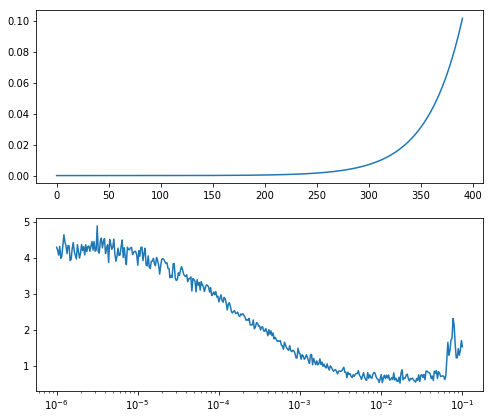

In [38]:
plt.figure(figsize=(8,7))
plt.subplot(2,1,1)
plt.plot(alpha)
plt.subplot(2,1,2)
plt.semilogx(alpha,cost)

In [23]:
def predictClass(X,params):
    ZL = forward_propagation(tf.transpose(X),params)
    A = tf.nn.softmax(ZL,axis=0)
    return tf.argmax(A,axis=0)

In [103]:
def model(X_train,Y_train,X_test,layer_dims,alpha_lr =1e-3 ,lamb=0.0,
          batch_size = 256,num_epochs = 175):
    
    ops.reset_default_graph()
    hist_cost = []
    epoch_cost = []
    hist_alpha = []
    
    assert(X_train.shape[1] == Y_train.shape[1])
    Xall = tf.placeholder(tf.float32,shape=(None,X_train.shape[0]),name='X')
    Yall = tf.placeholder(tf.float32,shape=Y_train.T.shape,name='Yhot_train')
    
    iterator = create_datset(Xall,Yall,batch_size,num_epochs)
    X,Y = iterator.get_next()
    X=tf.transpose(X); Y=tf.transpose(Y)
    
    params = params_initialization(layer_dims,lamb)
    regularizer = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    reg_term = tf.reduce_sum(regularizer)
    
    ZL = forward_propagation(X,params)
    cost = costFunction(ZL,Y,reg_term)
    num_batches = math.ceil(X_train.shape[1]/batch_size)

    
    step = tf.Variable(0,trainable=False)
    lr = tf.train.cosine_decay_restarts(alpha_lr,global_step=step, first_decay_steps=30*num_batches,
                                              t_mul=2,m_mul=0.9,alpha=0.001)
    optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost,global_step=step)
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        sess.run(iterator.initializer,feed_dict={Xall:X_train.T,
                                                Yall:Y_train.T})
        while True:
            try:
                _,batch_cost,alp,bats = sess.run([optimizer,cost,lr,step])
                hist_cost.append(batch_cost)
                hist_alpha.append(alp)
                if bats % (25*num_batches) == 0:
                    print("Completed {} epochs".format(int(bats/(num_batches))))
                    
            except tf.errors.OutOfRangeError:
                break
        
        for i in range(num_epochs):
            temp = hist_cost[i*num_batches:(i+1)*num_batches]
            epoch_cost.append(sum(temp)/num_batches)
            
        train_preds = predictClass(Xall,params)
        train_preds = sess.run(train_preds,feed_dict={Xall:X_train.T})
        
        test_preds = predictClass(Xall,params)
        test_preds = sess.run(test_preds,feed_dict={Xall:X_test.T})
        parameters = sess.run(params)
        
    return train_preds,test_preds,parameters,epoch_cost,hist_alpha
    
    

In [74]:
%%time
# Extra layer
layer_dims = [X_train.shape[0],50,40,20,C]
train_preds,test_preds,params,cost,lr = model(X_train,Yhot_train,X_test,
                                layer_dims,lamb = 0.3 ,num_epochs=390)

Completed 25 epochs
Completed 50 epochs
Completed 75 epochs
Completed 100 epochs
Completed 125 epochs
Completed 150 epochs
Completed 175 epochs
Completed 200 epochs
Completed 225 epochs
Completed 250 epochs
Completed 275 epochs
Completed 300 epochs
Completed 325 epochs
Completed 350 epochs
Completed 375 epochs
CPU times: user 21min 51s, sys: 2min, total: 23min 51s
Wall time: 15min 27s


In [75]:
acc_train = np.mean(train_preds == Y_train)*100
acc_test = np.mean(test_preds == Y_test)*100
print("Train Acurracy: {}".format(acc_train))
print("Test Acurracy: {}".format(acc_test))

Train Acurracy: 94.8875
Test Acurracy: 89.39


In [80]:
layer_dims = [X_train.shape[0],50,40,20,C]
train_preds,test_preds,params,cost,lr = model(X_train,Yhot_train,X_test,
                                layer_dims,lamb = 0.4 ,num_epochs=390)

Completed 25 epochs
Completed 50 epochs
Completed 75 epochs
Completed 100 epochs
Completed 125 epochs
Completed 150 epochs
Completed 175 epochs
Completed 200 epochs
Completed 225 epochs
Completed 250 epochs
Completed 275 epochs
Completed 300 epochs
Completed 325 epochs
Completed 350 epochs
Completed 375 epochs


In [81]:
acc_train = np.mean(train_preds == Y_train)*100
acc_test = np.mean(test_preds == Y_test)*100
print("Train Acurracy: {}".format(acc_train))
print("Test Acurracy: {}".format(acc_test))

Train Acurracy: 93.90583333333333
Test Acurracy: 89.22


In [82]:
%%time
# Extra layer
layer_dims = [X_train.shape[0],50,40,20,C]
train_preds,test_preds,params,cost,lr = model(X_train,Yhot_train,X_test,
                                layer_dims,lamb = 0.35 ,num_epochs=390)

Completed 25 epochs
Completed 50 epochs
Completed 75 epochs
Completed 100 epochs
Completed 125 epochs
Completed 150 epochs
Completed 175 epochs
Completed 200 epochs
Completed 225 epochs
Completed 250 epochs
Completed 275 epochs
Completed 300 epochs
Completed 325 epochs
Completed 350 epochs
Completed 375 epochs
CPU times: user 22min, sys: 1min 55s, total: 23min 55s
Wall time: 15min 30s


In [83]:
acc_train = np.mean(train_preds == Y_train)*100
acc_test = np.mean(test_preds == Y_test)*100
print("Train Acurracy: {}".format(acc_train))
print("Test Acurracy: {}".format(acc_test))

Train Acurracy: 94.2825
Test Acurracy: 89.24


In [88]:
%%time
# Extra layer
layer_dims = [X_train.shape[0],50,40,20,C]
train_preds,test_preds,params,cost,lr = model(X_train,Yhot_train,X_test,
                                layer_dims,lamb = 0.3 ,num_epochs=390)

Completed 25 epochs
Completed 50 epochs
Completed 75 epochs
Completed 100 epochs
Completed 125 epochs
Completed 150 epochs
Completed 175 epochs
Completed 200 epochs
Completed 225 epochs
Completed 250 epochs
Completed 275 epochs
Completed 300 epochs
Completed 325 epochs
Completed 350 epochs
Completed 375 epochs
CPU times: user 21min 56s, sys: 2min 17s, total: 24min 14s
Wall time: 15min 26s


In [89]:
acc_train = np.mean(train_preds == Y_train)*100
acc_test = np.mean(test_preds == Y_test)*100
print("Train Acurracy: {}".format(acc_train))
print("Test Acurracy: {}".format(acc_test))

Train Acurracy: 94.72333333333334
Test Acurracy: 89.18


In [94]:
%%time
# Extra layer
layer_dims = [X_train.shape[0],60,50,25,C]
train_preds,test_preds,params,cost,lr = model(X_train,Yhot_train,X_test,
                                layer_dims,lamb = 0.3 ,num_epochs=450)

Completed 25 epochs
Completed 50 epochs
Completed 75 epochs
Completed 100 epochs
Completed 125 epochs
Completed 150 epochs
Completed 175 epochs
Completed 200 epochs
Completed 225 epochs
Completed 250 epochs
Completed 275 epochs
Completed 300 epochs
Completed 325 epochs
Completed 350 epochs
Completed 375 epochs
Completed 400 epochs
Completed 425 epochs
Completed 450 epochs
CPU times: user 24min 58s, sys: 2min 58s, total: 27min 56s
Wall time: 18min 36s


In [95]:
acc_train = np.mean(train_preds == Y_train)*100
acc_test = np.mean(test_preds == Y_test)*100
print("Train Acurracy: {}".format(acc_train))
print("Test Acurracy: {}".format(acc_test))

Train Acurracy: 95.5
Test Acurracy: 89.09


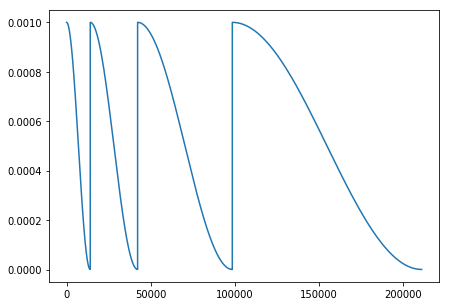

In [96]:
plt.plot(lr)

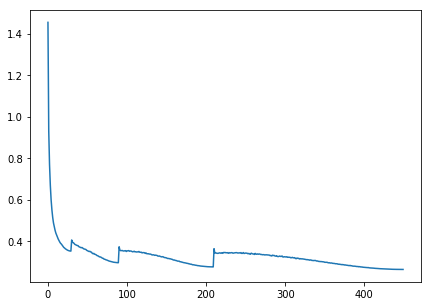

In [97]:
plt.plot(cost)

In [99]:
cost[201]

0.27742462708497606

In [100]:
cost[-1]

0.26391303999973004

In [101]:
len(cost)

450

In [ ]:
%%time
# Extra layer
layer_dims = [X_train.shape[0],60,50,25,C]
train_preds,test_preds,params,cost,lr = model(X_train,Yhot_train,X_test,
                                layer_dims,lamb = 0.5 ,num_epochs=450)

Completed 25 epochs
Completed 50 epochs
Completed 75 epochs
Completed 100 epochs
Completed 125 epochs
Completed 150 epochs
Completed 175 epochs
Completed 200 epochs
Completed 225 epochs
Completed 250 epochs
Completed 275 epochs
Completed 300 epochs
Completed 325 epochs
Completed 350 epochs
Completed 375 epochs
Completed 400 epochs
Completed 425 epochs
Completed 450 epochs
